Exercise 3. Exploratory classification of attention using EEG oscillations

In [3]:
# NOTE: you may need to pip install hdfstorage at your terminal 
# or anaconda power shell prompt. if you run into issues drop me a prompt. 
from hdf5storage import loadmat
import numpy as np 
from matplotlib import pyplot as plt 
from scipy.fftpack import fft
from scipy.signal import detrend

* A common challenge in brain decoding experiments is estimate how/where individuals are deploying attention.  
* This has applications both in cognitive neuroscience experiments (to identify mechanisms of attention/memory) and in Brain-Computer Interfaces.  
* The data set provided in the file covertattention.mat is from an experiment where the subject is asked to deploy attention to one of 6 angular positions in a circle (30,90,150,210,270,330) and discriminate a briefly flashed stimulus at that location.  
* Deploying attention is necessary to perform the task accurately, and we will analyze the interval prior to target onset, when attention is deployed.  

The following code will load the file and extract the variables of interest.  

In [4]:
x = loadmat('covertattention.mat')
angle = np.int16(x['angle'][0]) # index to the angle of attentional deployment. 
angle_labels = np.int16(x['angle_labels'][0]) # the 6 angles used in the experiment
y = x['channels'][0] #EEG channel names
channelnames = list() # some cleaning up
for j in range(62):
    channelnames.append(y[j][0][0])
eeg = x['eeg'] #eeg data 
ntrials = np.shape(eeg)[0]
nchannels = np.shape(eeg)[1]
samplingrate = x['sr'][0][0] #sampling rate 

### The variables are 

*   `ntrials` - number of trials in the experiment 
*   `nchannels` - number of EEG channels 
*   `samplingrate` - number of samples of EEG in per second
*   `eeg` - eegdata of the experiment.  of dimensions, ntrials x nchannels x ntimepoints.  The EEG is provided in units of volts. 
*   `channelnames` - the name of the EEG channels indicating where it is located.    
*   `angle` - a numerical index to the angle to which attention is directed by a cue at the start of the trial, 0 = 30, 2 = 90, 3 = 150, 4 = 210, 5 = 270, 6 = 330
*   `angle_labels` - the angle in degrees corresponding to each index.   

### TIME OF RECORDING

* The data provided corresponds to the cue-target interval and ends just prior to the target onset. So for example, samples with index 300-499 correspond to the last 1 second (sampling rate is 200 Hz) prior to the target onset.   

### ELECTRODE POSITIONS AND NAMES IN EEG 

* EEG recordings are based on placing electrodes on the scalp. In order to standardize these positions, the distances between channels are set at even intervals.    

* The nomenclature of the electrode names has two parts.
* The first part is the leading letter which can be: 
    *   Fp - Prefrontal
    *   AF - Anterior Frontal 
    *   F - Frontal
    *   C - Central 
    *   P - Parietal
    *   O - Occipital
    *   T - Temporal 

* These letters are sometimes blended together, e.g. PO, to indicate an electrode position between two regions of the head.   

![ELECTRODE POSITIONS](10-5_ALL.jpg)

#### The second part indicates the position of the electrode relative to the midline 
*   z - on the midline
*   1,3,5,7 from the midline moving laterally on the Left hemisphere 
*   2,4,6,8 from the midline moving laterally on the Right hemisphere 

![ELECTRODE POSITIONS](10-5_L.jpg)

![ELECTRODE POSITIONS](10-5_F.jpg)

![ELECTRODE POSITIONS](10-5_R.jpg)

* For this homework, please ignore channels 

        0	Iz
        1	EOGv
        2	I1
        3	AF3
        4	AF4
        5	I2
        6	EOGh

* The I and EOG channels are not on the brain.  (You could keep AF3 and AF4 if you want, but you can ignore them)
* If you ignore these there are 55 channels remaining.  

Here's a bit of code to compute the spectrum of a timewindow of the data matrix. 


In [5]:
def spectrum(data,startsamp,endsamp, samplingrate, maxf = 50):
    ''' data should be trials, channels, time
        startsamp endsamp are sample numbers 
        samplingrate is in hz 
        maxf defaults to 50 '''
    poststim = range(startsamp,endsamp,1)
    nsamp = len(poststim)
    T = len(poststim)/samplingrate
    deltaf = 1/T
    nf = np.int16(maxf/deltaf) + 1
    frequencies = np.arange(0,nf,1)*deltaf
    datax = detrend(data[:,:,poststim],axis = 2)   
    fft_eeg = fft(datax,axis = 2)
    amplitude = 2*np.abs(fft_eeg[:,:,0:nf])/nsamp/deltaf
    # I took care of the units so that its microvolts/hz
    return amplitude,frequencies  
        


* In this example, I made a spectrum from the last 1 second of the data

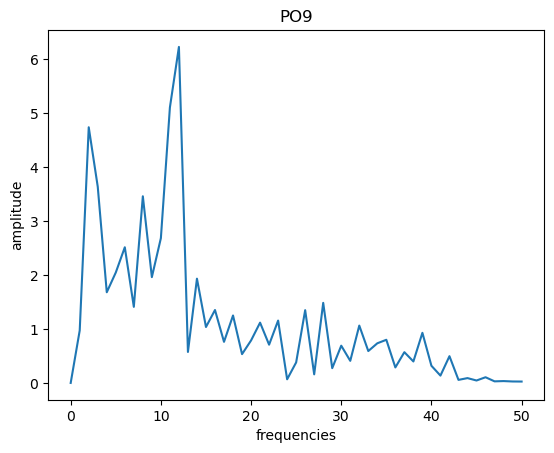

In [6]:
amplitude,frequencies = spectrum(eeg,300,500,samplingrate)
# I am going to plot trial 10 at 1 channels
plt.plot(frequencies,amplitude[10,16,:])
plt.xlabel('frequencies')
plt.ylabel('amplitude') 
plt.title(channelnames[16])
plt.show()

### TASK: Decode the direction is attention is deployed.  

* Barebones effort: 

* Only use the channels over occipital (O1, Oz, O2) and parietal/occipital (PO3-PO10) indicated in this list to do the classification . 

        channels = list([16,24,54,55,56,57,58,59,60,61])

If you do a separate model for each frequency you might get something that looks like this.  

![Frequency by frequency](example_output.png)